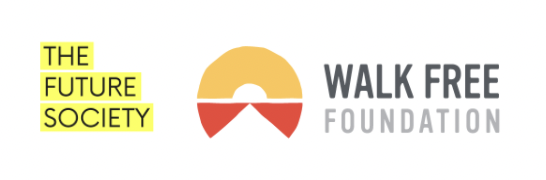

#*Project AIMS (AI against Modern Slavery)*
---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1zL37m7qtV1nj5x8VHH7bbOkh945yCV5O/view?usp=sharing).

##  Approval
 
 
### Was the company's Modern Slavery Act statement explicitly approved by the Board of Directors (or equivalent management body)?
 
This task aims to check if the statements provided by the companies are discussed and approved by the senior management level and the Board of Directors of the company. There should be a statement regarding this discussion and approval in the MSA statement.
 
The Modern Slavery Act requires that the statements be discussed at the senior management level and approved by the Board of Directors, Members, or Partners (who signs it depends on the type of company). This ensures senior-level accountability, leadership, and responsibility for modern slavery and gives it the serious attention it deserves. The statement should be approved by either:
 
The Board of Directors: a group of individuals that are elected as, or elected to act as, representatives of stakeholders to establish corporate management-related policies and to make decisions on significant issues. A member must sign when it is a limited liability partnership. A member is a partner in a business who is only liable for the money they invest in the business, not the business or other partners, or
 
A partner must sign when it is a limited partnership or any other type of organisation. Partners have management control, share the right to use partnership property, share the profits, and have joint and liability for debts of the partnership.
 
For more information, please refer to [WikiRate's UK Modern Slavery Act Research on MSA Statement Approval metric ](https://wikirate.org/Business_Human_Rights_Resource_Centre+MSA_Statement_Approval) or [Home Office Guidance, page 13.](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf)
 
 
### Labelled dataset
We are working with the initially categorical labels that we converted to binary. More specifically, if a report includes an explicit statement that the Board has approved it of Directors, the annotators selected the 'Approved by Board' label. If the statement has been explicitly approved by some entity or person other than the board of directors, the annotators selected 'Approved - not by Board'' and added the relevant sentence as a Comment. If no explicit approval can be found, the annotators selected the 'Approval not explicit in statement' label.
 
Statements with ‘Approved by Board’ and ‘Approved – not by Board’ are indicated as the statement is explicitly approved and hence indicated by metric ‘1’; otherwise, statements with ‘Approval not explicit in the statement’ are indicated as ‘0’.
 



## Setup

In [ ]:
#!pip install snorkel unidecode contractions

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


In [ ]:
import pandas as pd
import re
import snorkel
from snorkel.labeling import labeling_function, PandasLFApplier
from sklearn.metrics import classification_report
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
warnings.simplefilter('ignore')
from utils import sentencizer, evaluation_rb
from utils.preprocessing import *

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 🗄️ You can access the data used in this notebook [here ](https://drive.google.com/file/d/16gWHC4QOhzQ2EIad6YsQVYqzs0ZK2vZg/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).

In [ ]:
metric ='Business & Human Rights Resource Centre+MSA Statement Approval'   #metric that we need to label
file_name = 'approval_training_binary.csv'

data = load_dataset(metric, file_name) # load and remove duplicates and empty cells in TEXT and Label columns

Number of available statements for Business & Human Rights Resource Centre+MSA Statement Approval -> 911



In [ ]:
data[metric] = data[metric].astype(int)
print("Final number of data points in the labeled dataset is:")
print(data[metric].value_counts())

Final number of data points in the labeled dataset is:
1    583
0    328
Name: Business & Human Rights Resource Centre+MSA Statement Approval, dtype: int64


## Preprocessing
Some basic steps to pre-process statements are performed, which include:
- lemmatisation
- remove company names
- fix contractions (contraction is a shortened version of the spoken and written forms of a word)
- remove empty lines
- remove accents
- remove punctuation
- normalise text



In [ ]:
preprocessing = Preprocessing()
data['clean_text'] = data.TEXT.apply(lambda row: preprocessing(row))

Preprocessing...


In [ ]:
def print_side_by_side(str1, str2, size=30, space=4):
    while str1 or str2:
        print(str1[:size].ljust(size) + " " * space + str2[:size])
        str1 = str1[size:]
        str2 = str2[size:]


print_side_by_side(data.TEXT[0][:500], data.clean_text[0][:500])

Slavery and human trafficking     slavery and human trafficking 
statement 2018
1. Introduction    statement 2018 1 . introductio
 2. About our business 3. Our     n 2 . about business 3 . code 
code and human rights policy 4    and human right policy 4 . mod
. Modern slavery and our gover    ern slavery and governance 5 .
nance 5. Training 6. Assessing     train 6 . assess the risk of 
 the risk of modern slavery 7.    modern slavery 7 . manage mode
 Managing modern slavery risks    rn slavery risk 8 . work with 
 8. Working with others 9. Loo    other 9 . look ahead c 2019 sl
king ahead
© BP 2019

Slavery    avery and human trafficking st
 and human trafficking stateme    atement 2018 this statement re
nt 2018

This statement relate    late to the financial year end
s to the financial year ending     31 december 2018 . be publish
 31 December 2018. It is publi     by p.l.c . and relevant subsi
shed by BP p.l.c. and its rele    diaries1 in compliance with th
vant subsidiaries1 in com

## Synonyms
Thee synonyms of ‘slavery’, ‘approval’ and ‘statement for the labelling purpose’. And contrasting connectors are taken into consideration. For example, ‘slavery’ can be written as 'enslavement', 'servitude', 'subjugation', 'trafficking', 'forced labor', ‘forced labor’, ‘child labor’, ‘child labor’ and ‘training’ can be written as 'coaching', 'guidance', 'instruction', 'training', 'trained', 'educating'.



In [ ]:
synonyms_slavery = ['slavery', 'forced labor',"forced labour", "child labor", "child labour"]
synonyms_approval = ['approval', 'approved']
synonyms_statement = ['statement', 'document','report', 'declaration']
connectors = ['however', 'nevertheless']



dic_all_terms = {'slavery':synonyms_slavery,
                 'approval': synonyms_approval,
                 'statement': synonyms_statement,
                 'connectors': connectors}

In [ ]:
for key, list_terms in dic_all_terms.items():
    list_syns = []
    for term in list_terms:
         for syn in wordnet.synsets(term):
            for l in syn.lemmas():
                list_syns.append(l.name())
    print(key, set(list_syns))

slavery {'thrall', 'bondage', 'slaveholding', 'thraldom', 'thralldom', 'slavery'}
approval {'sanctioned', 'approving', 'approve', 'O.K.', 'commendation', 'okay', 'approved', 'approval', 'favourable_reception', 'sanction', 'favorable_reception', 'blessing'}
statement {'command', 'document', 'contract', 'financial_statement', 'written_document', 'paper', 'describe', 'story', 'papers', 'annunciation', 'statement', 'affirmation', 'program_line', 'write_up', 'declaration', 'written_report', 'instruction', 'reputation', 'text_file', 'announcement', 'theme', 'assertion', 'study', 'argument', 'account', 'cover', 'proclamation', 'resolve', 'news_report', 'report_card', 'composition', 'report', 'resolution'}
connectors {'all_the_same', 'still', 'nonetheless', 'notwithstanding', 'withal', 'even_so', 'however', 'yet', 'nevertheless'}


Out of the generated synonyms we select those that seem the most appropriate for the corpus.

In [ ]:
synonyms_slavery_extended = [
    'slavery', 
    'enslavement',
    'servitude',
    'subjugation',
    'trafficking', 
    'forced labor',
    'forced labour', 
    'child labor', 
    'child labour',
    'captivity', 
    'opression',
    'bondage',
    'slaveholding',
    'modern slavery act',
    'msa'
    ]

synonyms_approval_extended = [
    'approval',
    'approved',
    'approving'
    ]

connectors_extended = [
    'nevertheless',
    'notwithstanding', 
    'yet', 
    'however',
    'nonetheless',
    'even so'
    ]


synonyms_statement_extended = [
    'statement',
    'document',
    'report',
    'declaration'
    ]

In [ ]:
dic_final_terms = {
                'slavery': synonyms_slavery_extended,
                'approval': synonyms_approval_extended,
                'connectors': connectors_extended,
                'statement': synonyms_statement_extended
                  }



for key, val in dic_final_terms.items():
    dic_final_terms[key] = set(lemmatize_keywords(val))
    

## Labelling functions
The next step is to check if the key phrases are present in a particular statement of a company. To achieve that, two labelling functions are created to check statements with synonyms of keywords ‘slavery’ and ‘training’. Utilities from the Snorkel library like LFAnalysis are used to evaluate these labelling tasks. After collecting statistics about LFAnalysis, MajorityLabelVoter is used to perform the classification task to predict the label. The predicted variables are evaluated against their respective ground-truth value.
The output of the system is a prediction about whether a sentence could be classified as containing relevant information about the training or not.



In [ ]:
#helper functions for the labeling functions

def get_previous_next_sent(list_sent, sent_num):
    try:
        return list_sent[sent_num-1], list_sent[sent_num+1]
    except:
        None
        
def check_keyword(keyword_type, sent):
    return any(keyword in sent for keyword in dic_final_terms[keyword_type])

def check_all_elements(sent):
    if check_keyword('approval', sent) : #approval and statement keyword search
        if not check_keyword('connectors', sent): #make sure no opposition was found
            sent_tense = tense(sent)
            if sent_tense["future"]==0: #make sure the sentence is not in future tense 
                return YES
    
    return None
                 
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    return(tense)

In [ ]:
NO = 0
YES = 1
ABSTAIN = -1

@labeling_function()
def approval_keywords(x):
    
    """
    Keyword search 
    
    :param x: string representation of a document
    :return: binary label
    
    """
  
    sentences = sentencizer.main((str(x.clean_text).strip()))
    list_sent = [sent.lower() for sent in sentences]
    
    
    for i,sent in enumerate(list_sent):
        if check_keyword('slavery', sent) or check_keyword('statement', sent):
            if check_keyword('approval', sent):
                
                return YES
            
            if get_previous_next_sent(i, list_sent) != None:
                prev_sent, next_sent = get_previous_next_sent(i, list_sent)
                if 'it' in prev_sent and check_keyword('approval', prev_sent):
                    
                    return YES
  
    
            
    return NO


lfs = [approval_keywords]

applier = PandasLFApplier(lfs=lfs)
L_test_improved = applier.apply(df=data)



100%|██████████| 911/911 [09:45<00:00,  1.56it/s]


In [ ]:
majority_model = MajorityLabelVoter()
predicted_labels = majority_model.predict(L=L_test_improved) 

## Results

Using this method, we achieved 76% overall accuracy, 82% precision, and recall of 76%.



Evaluation of the rule-based model


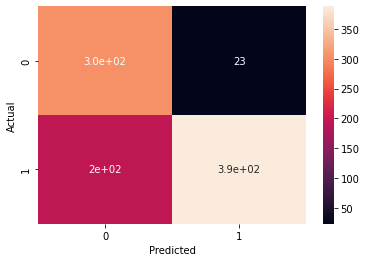

Confusion Matrix:
 [[305  23]
 [195 388]]
Accuracy Score: 0.7607025246981339
Precision Score: 0.8237702479294698
Recall Score: 0.7607025246981339
F1 Score: 0.7648532876786857


In [ ]:
evaluation_rb.main(data[metric], predicted_labels)

In [ ]:
print(classification_report(data[metric], predicted_labels))

              precision    recall  f1-score   support

           0       0.61      0.93      0.74       328
           1       0.94      0.67      0.78       583

    accuracy                           0.76       911
   macro avg       0.78      0.80      0.76       911
weighted avg       0.82      0.76      0.76       911



In [ ]:
def generate_output_func(row):   
   
    """ Extract sentence justifying assigned label for keywords_search function
        
        :param : row - row containing statement to be labeled
        :return: set of extracted sentences
    """
    sentences = sentencizer.main((str(row).strip()))
    list_sent = [sent.lower() for sent in sentences]
    
    result = []
    for i, sent in enumerate(list_sent):
        if check_keyword('slavery', sent):
            
            if get_previous_next_sent(i, list_sent) != None:
                prev_sent, next_sent = get_previous_next_sent(i, list_sent)
                prev_s = check_all_elements(prev_sent)
                current_s = check_all_elements(sent)
                next_s = check_all_elements(next_sent)

                if prev_s == YES:
                    result.append(prev_sent)
                if current_s == YES:
                    result.append(sent)
                if next_s == YES:
                    result.append(next_sent)
                else:
                    continue
            
            
            else:
                current_s = check_all_elements(sent)
                if current_s:
                    result.append(sent)
                else:
                    continue
    
    return set(result)

In [ ]:
generate_output_func(data.clean_text[0])

{'at the p.l.c . board level in 2018 the main board review and approve 2017 slavery and human trafficking statement and through safety ethic and environment assurance committee review approach to assess and manage risk associate with modern slavery .',
 'this statement have be approve by the board of p.l.c . and of each of relevant subsidiary in compliance with the uk modern slavery act .'}